In [150]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from scipy import stats
from itertools import combinations
import xgboost as xb
import warnings
from mlxtend.classifier import StackingClassifier
warnings.filterwarnings('ignore')
%matplotlib inline

In [91]:
titanic_train = pd.read_csv("train.csv")
titanic_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Data Cleaning and Preprocessing

First, it looks like we have a numerical feature that is really categorical, and which may be important for our classification, namely Pclass ( ticket class ). However, because there is a natural ordering of ticket classes that is expressed in their numbering, we should be fine if we just leave this as-is. 

PassengerId should have zero predictive effect, as it appears to be an arbitrary numbering. Names should also have no predictive effect. Any model that could use names to predict survival would likely be badly overfit. 

The variables we would expect to have predictive value here are Pclass, Sex, Age, SibSp, Parch, Fare, Cabin and Embarked. The predictive value of Embarked would likely be eaten up by other variables, but we'll leave it in anyway. 

At first glance, it looks as if Cabin is only a valid variable for passengers who travelled first-class. A closer examination of the data, however, shows that this is not the case. The vast majority of it is simply missing, we will have to delete it. 

There are many missing values for the Age variable. That data description says that estimated ages are prefixed with 'xx', however there are no cases of this in the training data. It seems reasonable to fill in missing values with the conditional expected value of Age given sex and ticket class. 

Ticket is a complex variable. Many of the values are numerical, but some have alphanumeric prefixes. There appears to 
be an association between the first number in a ticket and the associated class. It seems most reasonable to convert 
this to a categorical variable, there may be information here not contained in the other variables. 

### Check for missing values

In [92]:
mask = titanic_train.isnull()
missing = mask.sum(axis=0)
print(missing)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [93]:
#Drop Name
titanic_train = titanic_train.drop(['Name'], axis=1 )

In [95]:
#Drop passenger id
titanic_train = titanic_train.drop(['PassengerId'], axis=1 )

ValueError: labels ['PassengerId'] not contained in axis

### Deal with missing Cabin values

We'll just replace empty values with "Unk" for unknown

In [96]:
titanic_train['Cabin'].fillna("unk", inplace=True)
titanic_train['Cabin'] = titanic_train['Cabin'].apply(lambda x: x[0])

### Deal with missing values in 'Age'

In [97]:
# Find the median age for each combination of sex, ticket class and embarkation point
# I would try to do something with number of spouses etc., but they are mixed with number of siblings

missing_dict = {}
for tc, sex, ep in [ (t, s, e ) for t in (1, 2, 3) for s in ('male', 'female') for e in ('S', 'Q', 'C')]:
    #print( tc, sex, ep)
    i_set = titanic_train.index[ (titanic_train[ 'Pclass'] == tc) & (titanic_train['Sex'] == sex) & 
                                (titanic_train['Embarked'] == ep) ]
    rows = titanic_train.iloc[i_set]
    # Find where we have a missing age
    z_set = rows.index[ rows['Age'].isnull() ]
    med = rows['Age'].median()
    titanic_train['Age'].iloc[z_set] = med
    missing_dict[ (tc, sex, ep )] = med
    
titanic_train['Age'] = titanic_train['Age'].round(decimals=0)

In [98]:
#Print out our medians
print( missing_dict )

{(1, 'male', 'S'): 42.0, (1, 'male', 'Q'): 44.0, (1, 'male', 'C'): 36.5, (1, 'female', 'S'): 33.0, (1, 'female', 'Q'): 33.0, (1, 'female', 'C'): 37.0, (2, 'male', 'S'): 30.0, (2, 'male', 'Q'): 57.0, (2, 'male', 'C'): 29.5, (2, 'female', 'S'): 29.0, (2, 'female', 'Q'): 30.0, (2, 'female', 'C'): 22.0, (3, 'male', 'S'): 25.0, (3, 'male', 'Q'): 27.0, (3, 'male', 'C'): 26.0, (3, 'female', 'S'): 23.0, (3, 'female', 'Q'): 20.0, (3, 'female', 'C'): 14.25}


In [99]:
titanic_train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,u,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,u,S
3,1,1,female,35.0,1,0,113803,53.1000,C,S
4,0,3,male,35.0,0,0,373450,8.0500,u,S
5,0,3,male,27.0,0,0,330877,8.4583,u,Q
6,0,1,male,54.0,0,0,17463,51.8625,E,S
7,0,3,male,2.0,3,1,349909,21.0750,u,S
8,1,3,female,27.0,0,2,347742,11.1333,u,S
9,1,2,female,14.0,1,0,237736,30.0708,u,C


### Age cleaning results

As we can see, there is a fair bit of information contained in ticket class, sex, and embarkation point that impacts
mean age. If our initial classificaiton results are unsatisfactory, it might be worth checking other variables as
well to get a more granular estimate. 

### Missing values for Embarked

In [100]:
##That's just two values out of ~800 for embarked, so we'll just delete them rather than guess
missing_ind = titanic_train[ titanic_train['Embarked'].isnull()]
print( missing_ind.index )
titanic_train = titanic_train.drop( missing_ind.index )

Int64Index([61, 829], dtype='int64')


### Double check that we have no more missing values

In [101]:
mask = titanic_train.isnull()
missing = mask.sum(axis=0)
print(missing)

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
dtype: int64


### Pclass is a categorical variable, not numeric

In [102]:
#Pclass is categorical
titanic_train['Pclass'] = titanic_train['Pclass'].astype(str)
def p_conv( entry ):
    e_map = { '1' : 'first', '2': 'second', '3': 'third'}
    return e_map[entry]
titanic_train['Pclass'] = titanic_train['Pclass'].apply(p_conv)
titanic_train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,third,male,22.0,1,0,A/5 21171,7.2500,u,S
1,1,first,female,38.0,1,0,PC 17599,71.2833,C,C
2,1,third,female,26.0,0,0,STON/O2. 3101282,7.9250,u,S
3,1,first,female,35.0,1,0,113803,53.1000,C,S
4,0,third,male,35.0,0,0,373450,8.0500,u,S
5,0,third,male,27.0,0,0,330877,8.4583,u,Q
6,0,first,male,54.0,0,0,17463,51.8625,E,S
7,0,third,male,2.0,3,1,349909,21.0750,u,S
8,1,third,female,27.0,0,2,347742,11.1333,u,S
9,1,second,female,14.0,1,0,237736,30.0708,u,C


## Define a function to process ticket values

Ticket values are either completely numeric or have an alphabetic prefix to a numeric value.
It can also be hypothesized that, as there appears to be an association between the first number in a ticket
number and the class of that passenger, the first number in a ticket number is the most important. Past this,
it is likely that the number of digits is the most significant piece of information. 

We have, for instance, the ticket numbers "STON/O2. 3101282" and "36973". Six or seven digit ticket numbers starting
with 3 appear to always belong to third class passengers, whereas the five-digit number "36973" belongs to a 
first-class passenger. Similarly, six or sevendigit ticket numbers starting with 2 seem to indicate second class 
passengers.

For this reason, I think it best to convert this variable to a categorical variable defined as follows:
    alphanumeric prefix + first digit + number of digits

In [103]:
#How many different values are in the Ticket column before transformation?
len( titanic_train['Ticket'].unique() )

680

In [104]:
#define a function to transform ticket numbers
def ticket_number_processor( ticket_num_array ):
    regex = re.compile('[^a-zA-Z]') #for stripping punctuation from prefixes
    ticket_num = []
    ticket_prefix = []
    for x in range(0, len(ticket_num_array)):
        #there is always whitespace between the prefix and the ticket number
        parts = ticket_num_array[x].split(' ')
        if len(parts) > 1: #we have a prefix
            ticket_prefix.append ( re.sub( regex, '', parts[0] )[:2] ) ##From examing the data, it would appear this much detail is 
            ##sufficient, and indeed optimal. Many of the ticket numbers appear almost identical except for a punct mark
            ticket_num.append( parts[1][0] + str( len(parts[1] )) )
        else: #no prefix
            ticket_prefix.append ("None" ) 
            ticket_num.append( parts[0][0] + str( len(parts[0])) )
    return np.array(ticket_num), np.array(ticket_prefix)      

In [105]:
ticket_nums = titanic_train['Ticket'].as_matrix()
tn, tp = ticket_number_processor( ticket_nums )
titanic_train['TickPrefix'] = pd.Series( tp, index=titanic_train.index )
titanic_train['TickNum'] = pd.Series( tn, index=titanic_train.index )

In [106]:
# Check Ticket column
titanic_train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TickPrefix,TickNum
0,0,third,male,22.0,1,0,A/5 21171,7.2500,u,S,A,25
1,1,first,female,38.0,1,0,PC 17599,71.2833,C,C,PC,15
2,1,third,female,26.0,0,0,STON/O2. 3101282,7.9250,u,S,ST,37
3,1,first,female,35.0,1,0,113803,53.1000,C,S,None,16
4,0,third,male,35.0,0,0,373450,8.0500,u,S,None,36
5,0,third,male,27.0,0,0,330877,8.4583,u,Q,None,36
6,0,first,male,54.0,0,0,17463,51.8625,E,S,None,15
7,0,third,male,2.0,3,1,349909,21.0750,u,S,None,36
8,1,third,female,27.0,0,2,347742,11.1333,u,S,None,36
9,1,second,female,14.0,1,0,237736,30.0708,u,C,None,26


In [107]:
#How many unique values are in the Ticket column after our transformation?
print( "Number of unique TickNum entries: %d" % len(titanic_train['TickNum'].unique()))
print( "Number of unique TickPrefix entries: %d" % len(titanic_train['TickPrefix'].unique()))

Number of unique TickNum entries: 26
Number of unique TickPrefix entries: 16


We don't want a value in this categorical variable that occurs once, or only a few times. 

In [108]:
unq = titanic_train['TickPrefix'].unique() #get a list of every unique value in 'Ticket' column
tp_cdict = {} 
tn_cdict = {}
for val in unq:
    tp_cdict[val] = len ( titanic_train.index[ titanic_train['TickPrefix'] == val ])
print( "TickPrefix: ")
print( tp_cdict )

unq = titanic_train['TickNum'].unique() #get a list of every unique value in 'Ticket' column
count_dict = {} 
for val in unq:
    tn_cdict[val] = len ( titanic_train.index[ titanic_train['TickNum'] == val ])
print("TickNum")
print( tn_cdict )

TickPrefix: 
{'A': 28, 'PC': 60, 'ST': 18, 'None': 663, 'PP': 5, 'CA': 42, 'SC': 17, 'SP': 1, 'SO': 27, 'WC': 10, 'WE': 3, 'C': 5, 'Fa': 1, 'FC': 6, 'SW': 2, 'AS': 1}
TickNum
{'25': 45, '15': 149, '37': 32, '16': 70, '36': 263, '26': 88, '94': 3, '24': 97, '74': 12, '35': 43, '34': 15, '14': 10, '64': 9, '54': 5, '44': 12, '22': 12, '55': 3, '83': 1, 'L4': 4, '73': 3, '65': 3, 'B5': 1, '45': 3, '63': 2, '84': 2, '31': 2}


In [109]:
#functions to deal with uncommon values in TicketPref and TicketNum
def tp_uncommon( prefix ):
    if tp_cdict[ prefix ] < 6:
        return "Unc"
    else: return prefix

def tn_uncommon( prefix ):
    if tn_cdict[ prefix ] < 10:
        return "Unc"
    else: return prefix

titanic_train['TickPrefix'] = titanic_train['TickPrefix'].apply( tp_uncommon )
titanic_train['TickNum'] = titanic_train['TickNum'].apply( tn_uncommon )

In [110]:
titanic_train = titanic_train.drop(['Ticket'], axis=1)
titanic_train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,TickPrefix,TickNum
0,0,third,male,22.0,1,0,7.2500,u,S,A,25
1,1,first,female,38.0,1,0,71.2833,C,C,PC,15
2,1,third,female,26.0,0,0,7.9250,u,S,ST,37
3,1,first,female,35.0,1,0,53.1000,C,S,None,16
4,0,third,male,35.0,0,0,8.0500,u,S,None,36
5,0,third,male,27.0,0,0,8.4583,u,Q,None,36
6,0,first,male,54.0,0,0,51.8625,E,S,None,15
7,0,third,male,2.0,3,1,21.0750,u,S,None,36
8,1,third,female,27.0,0,2,11.1333,u,S,None,36
9,1,second,female,14.0,1,0,30.0708,u,C,None,26


In [111]:
#How many unique values are in the Ticket column after our transformation?
print( "Number of unique TickNum entries: %d" % len(titanic_train['TickNum'].unique()))
print( "Number of unique TickPrefix entries: %d" % len(titanic_train['TickPrefix'].unique()))

Number of unique TickNum entries: 14
Number of unique TickPrefix entries: 10


681 to 28 is a pretty good reduction, although we still have a relatively small sample for that many different values.
There are model types that can handle this, however.


## Normality

Fare and age our only two real numeric variables, and as we can see below neither is normally distributed. 

In [112]:
##print out some basic statistics about our response's distribution
print("Fare Std: %f" % titanic_train['Fare'].std())
print("Fare Skewness: %f" % titanic_train['Fare'].skew() )
print( "Fare Kurtosis: %f" % titanic_train['Fare'].kurt() )
print("Age Std: %f" % titanic_train['Age'].std())
print("Age Skewness: %f" % titanic_train['Age'].skew() )
print( "Age Kurtosis: %f" % titanic_train['Age'].kurt() )

Fare Std: 49.697504
Fare Skewness: 4.801440
Fare Kurtosis: 33.508477
Age Std: 13.328633
Age Skewness: 0.516860
Age Kurtosis: 0.675976


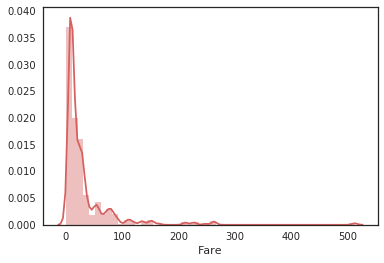

In [113]:
##Investigate Fare
sns.set(style="white", palette="muted", color_codes=True)
#histogram plot for our response variable
sns.distplot(titanic_train['Fare'], color='r')

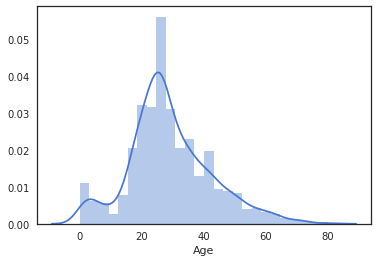

In [114]:
##Investigate Age
sns.set(style="white", palette="muted", color_codes=True)
#histogram plot for our response variable
sns.distplot(titanic_train['Age'], color='b')

Age is probably fine as-is. Fare, however, is highly skewed in the positive direciton. We will try Box-Cox. 

In [115]:
#titanic_train['Fare'] = titanic_train['Fare'].apply( lambda x: x+1 )#add one for zero values

In [116]:
""""
values = titanic_train['Fare'].values
values.shape
titanic_train['Fare'], _ = stats.boxcox( values )
"""

'"\nvalues = titanic_train[\'Fare\'].values\nvalues.shape\ntitanic_train[\'Fare\'], _ = stats.boxcox( values )\n'

In [117]:
##Investigate Fare
""""
sns.set(style="white", palette="muted", color_codes=True)
#histogram plot for our response variable
sns.distplot(titanic_train['Fare'], color='r')
print("Fare Std: %f" % titanic_train['Fare'].std())
print("Fare Skewness: %f" % titanic_train['Fare'].skew() )
print( "Fare Kurtosis: %f" % titanic_train['Fare'].kurt() )
"""

'"\nsns.set(style="white", palette="muted", color_codes=True)\n#histogram plot for our response variable\nsns.distplot(titanic_train[\'Fare\'], color=\'r\')\nprint("Fare Std: %f" % titanic_train[\'Fare\'].std())\nprint("Fare Skewness: %f" % titanic_train[\'Fare\'].skew() )\nprint( "Fare Kurtosis: %f" % titanic_train[\'Fare\'].kurt() )\n'

## Feature Engineering

Embarked needs a one-hot encoding.

Ticket number and sex need to be encoded numerically. 

We'll generate some new features by combining previous features. 

In [119]:
#split numeric and categorical features
#categorical, get dummy variables
titanic_cat = titanic_train[['Pclass', 'Sex', 'Embarked', 'TickPrefix', 'TickNum', 'Cabin']]
titanic_cat = pd.get_dummies( titanic_cat )
#numeric
titanic_num = titanic_train[['Age', 'Fare', 'Parch', 'SibSp']]
titanic_cat.head(10)

,Pclass_first,Pclass_second,Pclass_third,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,TickPrefix_A,TickPrefix_CA,...,TickNum_Unc,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_u
0,0,0,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
7,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
8,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
9,0,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [120]:
titanic_num.head(10)

,Age,Fare,Parch,SibSp
0,22.0,7.2500,0,1
1,38.0,71.2833,0,1
2,26.0,7.9250,0,0
3,35.0,53.1000,0,1
4,35.0,8.0500,0,0
5,27.0,8.4583,0,0
6,54.0,51.8625,0,0
7,2.0,21.0750,1,3
8,27.0,11.1333,2,0
9,14.0,30.0708,0,1


### Correlation Heatmaps for Categorical Features

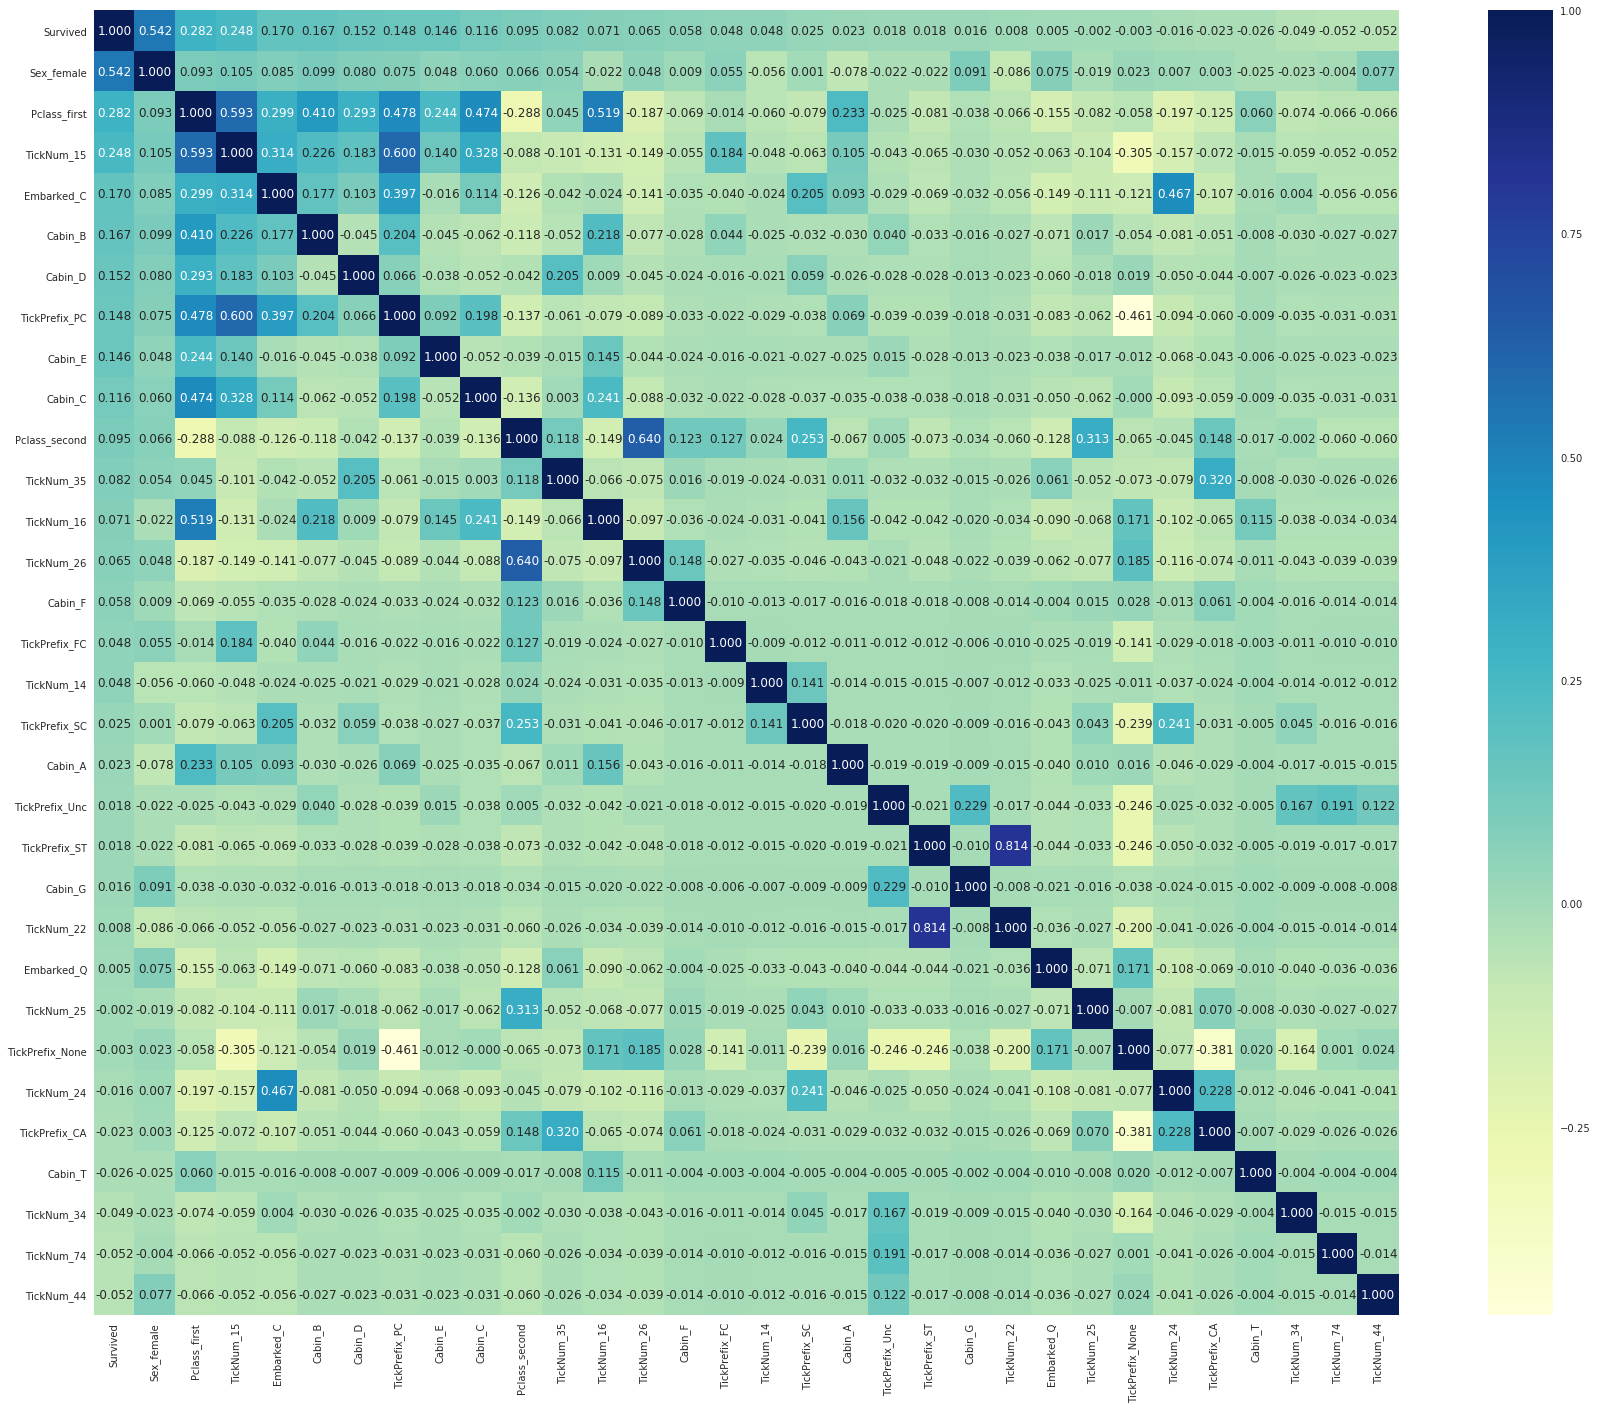

In [121]:
##build a correlation heatmap using the ~10 highest correlated predictors
f, ax = plt.subplots(figsize=(32, 24))
titanic_cat['Survived'] = titanic_train['Survived']
correlation_matrix = titanic_cat.corr()
cols = correlation_matrix.nlargest(32, 'Survived')['Survived'].index
cm = np.corrcoef( titanic_cat[cols].values.T)
sns.set(font_scale=1.0)
hm = sns.heatmap(cm, cbar=True, cmap="YlGnBu", annot=True, square=True, fmt='.3f', annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### New Features: From Numerical

Our three numerical features are Age, SibSp, Parch, and Fare. We can make some new features here by adding polynomials
on them, additive features with their combinations, and multiplicative features with their combinations

In [122]:
#Check the normality of some of our important predictors
for pred in list(titanic_num.columns.values):
    print( "Results for " + pred + ":" )
    print(stats.normaltest( titanic_num[pred]))
# The p-values reported here are for the null hypothesis that the variable is from a normal distribution
# As we can see, the majority of these variables are likely not from such a distribution
# The 'statistic' value is skewness squared plus kurtosis squared. Many of the non-normal variables have high 
# skewness, kurtosis or both

Results for Age:
NormaltestResult(statistic=46.317508076587352, pvalue=8.755499214728063e-11)
Results for Fare:
NormaltestResult(statistic=904.42114693266649, pvalue=4.0498905395992859e-197)
Results for Parch:
NormaltestResult(statistic=541.0561334080254, pvalue=3.2445422248648065e-118)
Results for SibSp:
NormaltestResult(statistic=720.58155947033254, pvalue=3.3705632432651391e-157)


In [123]:
#I will apply log-transform to all features where we reject null hypothesis, alpha = 0.01
def get_p( x ):
    s, p = stats.normaltest(x)
    return p
alpha = 0.01
norm_p = titanic_num.apply(lambda x : get_p(x))
norm_p = norm_p[norm_p < alpha]
print(str(norm_p.shape[0]) + " numerical features to log transform")
logt_features = norm_p.index
titanic_num[logt_features] = np.log1p(titanic_num[logt_features])

4 numerical features to log transform


In [124]:
rb = StandardScaler()
def scale_num( df, n_features ):
    for f in n_features:
        df[f] = rb.fit_transform( df[f].as_matrix().reshape(-1,1))
        
def add_quads( df, n_features ):
    for f in n_features:
        df[f + '^2'] = df[f]**2
        
def add_cubes( df, n_features ):
    for f in n_features:
        df[f + '^3'] = df[f]**3
        
def add_additives( df, n_features ):
    combs = list( combinations( n_features, 2 ) )
    for c in combs:
        df[c[0] + '+' + c[1]] = df[c[0]] + df[c[1]]
        
def add_mults( df, n_features ):
    combs = list( combinations( n_features, 2 ) )
    for c in combs:
        df[c[0] + '*' + c[1]] = df[c[0]] * df[c[1]]

num_features = ['Age', 'Fare', 'SibSp', 'Parch']

#scaling
scale_num( titanic_num, num_features )
#polynomials
add_quads( titanic_num, num_features )
add_cubes( titanic_num, num_features )
#additive
add_additives( titanic_num, num_features )
#multiplicative
add_mults( titanic_num, num_features )

In [125]:
titanic_num.head(10)

,Age,Fare,Parch,SibSp,Age^2,Fare^2,SibSp^2,Parch^2,Age^3,Fare^3,...,Age+Parch,Fare+SibSp,Fare+Parch,SibSp+Parch,Age*Fare,Age*SibSp,Age*Parch,Fare*SibSp,Fare*Parch,SibSp*Parch
0,-0.210340,-0.877591,-0.529822,0.887167,0.044243,0.770166,0.787065,0.280711,-0.009306,-0.675891,...,-0.740162,0.009576,-1.407413,0.357345,0.184593,-0.186607,0.111443,-0.778570,0.464967,-0.470041
1,0.642837,1.366380,-0.529822,0.887167,0.413240,1.866993,0.787065,0.280711,0.265646,2.551022,...,0.113015,2.253546,0.836558,0.357345,0.878360,0.570304,-0.340589,1.212207,-0.723938,-0.470041
2,0.048719,-0.796281,-0.529822,-0.610219,0.002374,0.634064,0.372368,0.280711,0.000116,-0.504893,...,-0.481103,-1.406501,-1.326103,-1.140041,-0.038794,-0.029729,-0.025812,0.485906,0.421887,0.323308
3,0.513516,1.066796,-0.529822,0.887167,0.263698,1.138053,0.787065,0.280711,0.135413,1.214071,...,-0.016306,1.953963,0.536974,0.357345,0.547816,0.455574,-0.272072,0.946426,-0.565212,-0.470041
4,0.513516,-0.781901,-0.529822,-0.610219,0.263698,0.611370,0.372368,0.280711,0.135413,-0.478031,...,-0.016306,-1.392121,-1.311723,-1.140041,-0.401519,-0.313357,-0.272072,0.477131,0.414269,0.323308
5,0.107477,-0.736277,-0.529822,-0.610219,0.011551,0.542104,0.372368,0.280711,0.001241,-0.399139,...,-0.422345,-1.346496,-1.266099,-1.140041,-0.079133,-0.065584,-0.056944,0.449290,0.390096,0.323308
6,1.198256,1.042871,-0.529822,-0.610219,1.435816,1.087581,0.372368,0.280711,1.720475,1.134207,...,0.668433,0.432652,0.513049,-1.140041,1.249626,-0.731199,-0.634862,-0.636380,-0.552536,0.323308
7,-3.501250,0.140014,1.153464,2.384553,12.258749,0.019604,5.686093,1.330479,-42.920939,0.002745,...,-2.347786,2.524567,1.293478,3.538017,-0.490223,-8.348915,-4.038565,0.333870,0.161501,2.750496
8,0.107477,-0.478771,2.138123,-0.610219,0.011551,0.229222,0.372368,4.571570,0.001241,-0.109745,...,2.245600,-1.088990,1.659352,1.527904,-0.051457,-0.065584,0.229799,0.292155,-1.023672,-1.304724
9,-0.900945,0.493427,-0.529822,0.887167,0.811701,0.243470,0.787065,0.280711,-0.731298,0.120135,...,-1.430767,1.380593,-0.036395,0.357345,-0.444550,-0.799288,0.477340,0.437752,-0.261428,-0.470041


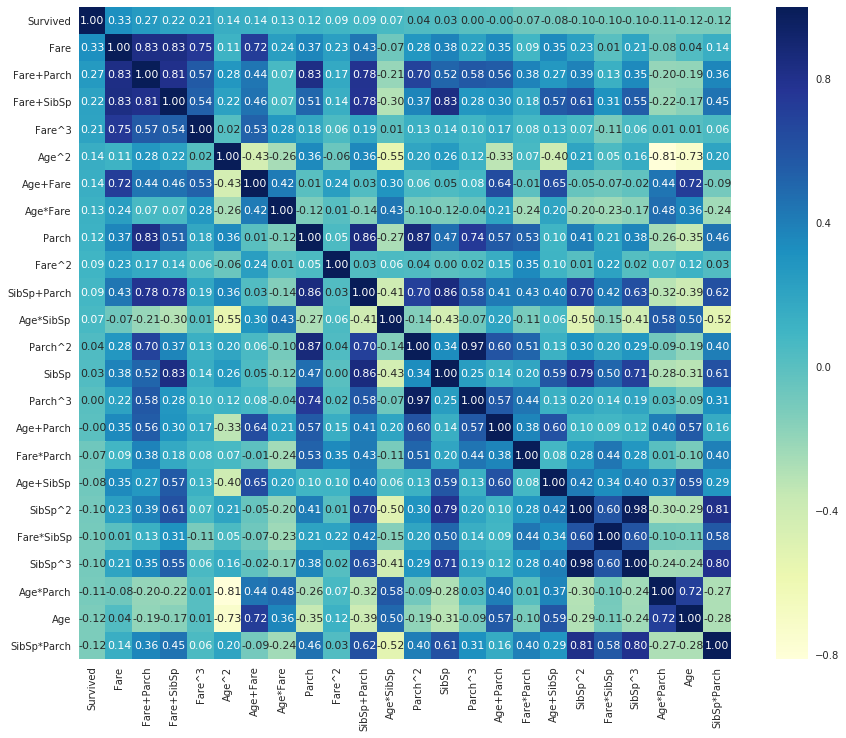

In [126]:
##build a correlation heatmap using the ~10 highest correlated predictors
titanic_num['Survived'] = titanic_train['Survived']
f, ax = plt.subplots(figsize=(16, 12))
correlation_matrix = titanic_num.corr()
cols = correlation_matrix.nlargest(24, 'Survived')['Survived'].index
cm = np.corrcoef(titanic_num[cols].values.T)
sns.set(font_scale=1.0)
hm = sns.heatmap(cm, cbar=True, cmap="YlGnBu", annot=True, square=True, fmt='.2f', annot_kws={'size': 11}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [127]:
mask = titanic_num.isnull()
missing = mask.sum(axis=0)
print(missing)

Age            0
Fare           0
Parch          0
SibSp          0
Age^2          0
Fare^2         0
SibSp^2        0
Parch^2        0
Age^3          0
Fare^3         0
SibSp^3        0
Parch^3        0
Age+Fare       0
Age+SibSp      0
Age+Parch      0
Fare+SibSp     0
Fare+Parch     0
SibSp+Parch    0
Age*Fare       0
Age*SibSp      0
Age*Parch      0
Fare*SibSp     0
Fare*Parch     0
SibSp*Parch    0
Survived       0
dtype: int64


### Initial Models

Build some initial models to further assess how useful our new features are, and to benchmark performance.

In [128]:
y = titanic_train['Survived']
titanic_num = titanic_num.drop(['Survived'], axis=1)
titanic_cat = titanic_cat.drop(['Survived'], axis=1)
titanic_cat.reset_index(drop=True, inplace=True)
titanic_num.reset_index(drop=True, inplace=True)

In [129]:
titanic_cat.head(10)

,Pclass_first,Pclass_second,Pclass_third,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,TickPrefix_A,TickPrefix_CA,...,TickNum_Unc,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_u
0,0,0,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
7,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
8,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
9,0,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [130]:
titanic_cat.shape

(889, 41)

In [131]:
X = pd.concat( [titanic_num, titanic_cat], axis=1)
y.head(5)

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [132]:
X.head(5)

,Age,Fare,Parch,SibSp,Age^2,Fare^2,SibSp^2,Parch^2,Age^3,Fare^3,...,TickNum_Unc,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_u
0,-0.210340,-0.877591,-0.529822,0.887167,0.044243,0.770166,0.787065,0.280711,-0.009306,-0.675891,...,0,0,0,0,0,0,0,0,0,1
1,0.642837,1.366380,-0.529822,0.887167,0.413240,1.866993,0.787065,0.280711,0.265646,2.551022,...,0,0,0,1,0,0,0,0,0,0
2,0.048719,-0.796281,-0.529822,-0.610219,0.002374,0.634064,0.372368,0.280711,0.000116,-0.504893,...,0,0,0,0,0,0,0,0,0,1
3,0.513516,1.066796,-0.529822,0.887167,0.263698,1.138053,0.787065,0.280711,0.135413,1.214071,...,0,0,0,1,0,0,0,0,0,0
4,0.513516,-0.781901,-0.529822,-0.610219,0.263698,0.611370,0.372368,0.280711,0.135413,-0.478031,...,0,0,0,0,0,0,0,0,0,1


In [133]:
kn = KNeighborsClassifier(n_neighbors=20)
print( cross_val_score(kn, X, y ))

[ 0.69023569  0.73986486  0.81081081]


In [134]:
svc = svm.SVC()
print( cross_val_score(svc, X, y))

[ 0.79461279  0.80743243  0.79391892]


In [135]:
log_reg = LogisticRegression(C=0.7, solver='liblinear', tol=1e-8)
print( cross_val_score(log_reg, X, y))

[ 0.80808081  0.82094595  0.82432432]


In [136]:
ada = AdaBoostClassifier()
print( cross_val_score( ada, X, y))

[ 0.76767677  0.79391892  0.81418919]


In [137]:
"""
Cs = np.array( [ 0.5,0.6, 0.7, 0.8, 0.9] )
tols = np.array( [1e-8, 1e-9, 1e-10, 1e-7 ])
solvers = np.array( ['lbfgs', 'liblinear', 'sag', 'saga'])
param_grid =  { 'C' : Cs, 'tol' : tols, 'solver' : solvers }
gs = GridSearchCV( LogisticRegression(), param_grid )
gs.fit( X, y )
"""

"\nCs = np.array( [ 0.5,0.6, 0.7, 0.8, 0.9] )\ntols = np.array( [1e-8, 1e-9, 1e-10, 1e-7 ])\nsolvers = np.array( ['lbfgs', 'liblinear', 'sag', 'saga'])\nparam_grid =  { 'C' : Cs, 'tol' : tols, 'solver' : solvers }\ngs = GridSearchCV( LogisticRegression(), param_grid )\ngs.fit( X, y )\n"

In [138]:
"""
gs.best_score_
0.82002249718785147
"""

'\ngs.best_score_\n0.82002249718785147\n'

In [139]:
"""
gs.best_params_
{'C': 0.69999999999999996, 'solver': 'liblinear', 'tol': 1e-08}
"""

"\ngs.best_params_\n{'C': 0.69999999999999996, 'solver': 'liblinear', 'tol': 1e-08}\n"

In [140]:
"""
Cs = np.array( [ 300, 400, 500, 600, 700 ] )
gammas = np.array( [2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4] )

param_grid =  { 'C' : Cs, 'gamma' : gammas }
gs = GridSearchCV( svm.SVC(), param_grid )
gs.fit( X, y )
"""

"\nCs = np.array( [ 300, 400, 500, 600, 700 ] )\ngammas = np.array( [2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4] )\n\nparam_grid =  { 'C' : Cs, 'gamma' : gammas }\ngs = GridSearchCV( svm.SVC(), param_grid )\ngs.fit( X, y )\n"

In [141]:
"""
gs.best_score_
0.82789651293588307
"""

'\ngs.best_score_\n0.82789651293588307\n'

In [142]:
"""
gs.best_params_
{'C': 500, 'gamma': 0.00029999999999999997}
"""

"\ngs.best_params_\n{'C': 500, 'gamma': 0.00029999999999999997}\n"

In [143]:
#XGBoost
"""
max_depths = np.array( [6, 7, 8 ] )
min_child_weights = np.array( [4, 5, 6, 7] )
learning_weights = np.array( [ 0.13, 0.14, 0.15, 0.16, 0.17 ] )
n_estimators = np.array( [50, 75, 80, 90, 100])
param_grid = { 'max_depth' : max_depths, 'min_child_weight' : min_child_weights, 'learning_rate' : learning_weights,
             'n_estimators' : n_estimators }
xgb = xb.XGBClassifier()
gs = GridSearchCV( xgb, param_grid )
"""

"\nmax_depths = np.array( [6, 7, 8 ] )\nmin_child_weights = np.array( [4, 5, 6, 7] )\nlearning_weights = np.array( [ 0.13, 0.14, 0.15, 0.16, 0.17 ] )\nn_estimators = np.array( [50, 75, 80, 90, 100])\nparam_grid = { 'max_depth' : max_depths, 'min_child_weight' : min_child_weights, 'learning_rate' : learning_weights,\n             'n_estimators' : n_estimators }\nxgb = xb.XGBClassifier()\ngs = GridSearchCV( xgb, param_grid )\n"

In [144]:
"""
gs.fit(X,y)
"""

'\ngs.fit(X,y)\n'

In [145]:
"""
gs.best_score_
0.83914510686164234
"""

'\ngs.best_score_\n0.83914510686164234\n'

In [146]:
"""
gs.best_params_
{'learning_rate': 0.14999999999999999,
 'max_depth': 6,
 'min_child_weight': 6,
 'n_estimators': 75}
 """

"\ngs.best_params_\n{'learning_rate': 0.14999999999999999,\n 'max_depth': 6,\n 'min_child_weight': 6,\n 'n_estimators': 75}\n "

In [147]:
gb = GaussianNB()
print( cross_val_score(gb, X, y))

[ 0.63973064  0.58445946  0.75337838]


In [152]:
rf = RandomForestClassifier(n_estimators=100)
print( cross_val_score(rf, X, y))

[ 0.7979798   0.83783784  0.82432432]


In [153]:
mlp = MLPClassifier()
print( cross_val_score(mlp, X, y))

NameError: name 'MLPClassifier' is not defined

In [148]:
#'C': 0.69999999999999996, 'solver': 'liblinear', 'tol': 1e-08
log_reg = LogisticRegression(C=7, solver='liblinear', tol=1e-8)
svc = svm.SVC(C=500, gamma=0.0003)
xgb = xb.XGBClassifier( learning_rate=0.15, max_depth=6, min_child_weight=6, n_estimators=75)
meta_xgb = LogisticRegression()
stack = StackingClassifier( classifiers=[log_reg, svc, xgb], meta_classifier=meta_xgb)
print( cross_val_score(stack, X, y))

[ 0.78451178  0.83783784  0.83445946]
